In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from py2neo import Graph, Node, Relationship
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget

%matplotlib inline

In [2]:
# Neo4j database connection details
# Please change this details to your corresponding server information
db_url = 'bolt://localhost:7687'
db_username = 'neo4j'
db_password = '12345678'

In [3]:
# Establishing a connection with Neo4j database
# NB: Ensure your Neo4j database server is running before running the cell
try:
    # py2neo
    graph = Graph(db_url, auth=(db_username, db_password))
    # neo4j
    driver = GraphDatabase.driver(uri=db_url,auth=(db_username,db_password))
    session = driver.session()
except:
    print('Please ensure your graph database server is running and accurate information are provided')

In [4]:
# URL to the dataset
url = 'https://data.snb.ch/api/cube/auvercurra/data/csv/en'

In [5]:
# Import csv files
def import_csv(url, header=None):
    df = pd.read_csv(url, header=header, skiprows=[0,1], sep=';')
    print('Dataset imported')
    return df

# Printing the dataset shape
def data_shape(df):
    print(f'Shape of data: {df.shape}\n')

# Printing the dataset information 
def data_details(df):
    print(f'{df.describe()}\n{df.info()}\n')

# Checking for missing values
def check_na(df):
    print(f'NULL COUNT\n{df.isna().sum()}\n')

# Viewing samples of the dataset
def data_preview(df, num):
    print(f'{df.head(num)}\n')

# Getting the latest year with missing value
def max_empty_entry_year(df):
    empty_entry_years = []
    
    # Iterate over the data
    for i in range(len(df)):
        
        # Test if the value is empty
        if pd.isna(df['Value'][i]) == True:
            temp_year = df['Date'][i]
            empty_entry_years.append(temp_year)
    return max(empty_entry_years)

# Acquire sequential years with complete values
def get_complete_year(df):
    # Get the latest year with missing value
    start_year = max_empty_entry_year(df)
    
    # Get the last year on the data
    end_year = df.iloc[0,-1]

    # Extract years with complete data between the latest year with missing value and last year on the data
    new_df = df[((df['Date'] > start_year)&(df['Date']<= end_year))]
    new_df.reset_index(drop=True, inplace=True)
    return new_df

# Rename columns
def col_rename(df, dic):
    df.rename(columns=dic, inplace=True)

# Replace values in the dataframe
def replace_values(df, dic):
    for temp_col in dic:
        df[temp_col] = df[temp_col].map(dic[temp_col]).fillna(df[temp_col])

# Extract unique values in the dataframe
def extract_unique_values(df, col):
   for i in col:
      if i == 'Category':
         category = df[i].unique()
      elif i == 'Currency':
         currency = df[i].unique()
      elif i == 'Investment':
         investment = df[i].unique()
   return category, currency, investment

# Plot trend line
def plot_trend(df, layer, layer1, layer2):
    
    # Duplicate the dataframe
    temp_df = df.copy(deep=True)
    
    # Scaling of 'Value' column
    temp_df['Value'] = temp_df['Value']/1000
    
    # Filter the data
    for i in layer1:
        filter_df_1 = temp_df[temp_df[layer[0]] == i]
        for j in layer2:
            filter_df_2 = filter_df_1[filter_df_1[layer[1]] == j]
            
            # Check if the dataframe is empty
            if filter_df_2.empty == True:
                print(f'There is no {i} for {j}.')
                continue
            
            # Set the plot style (optional)
            sns.set(style="whitegrid")

            # Plot the trend using Seaborn
            plt.figure(figsize=(10, 6))  # Set the figure size
            
            for _, val in enumerate(filter_df_2[layer[2]].unique()):
                filter_df_3 = filter_df_2[filter_df_2[layer[2]] == val]
                sns.lineplot(x='Date', y='Value', data=filter_df_3, label=val)

            # Customize the plot
            plt.xticks(temp_df['Date'].unique(), rotation=45)
            plt.title(f'{j} ({i})')
            plt.xlabel('Year')
            plt.ylabel('Values (in Billions)')
            plt.legend()

            # Show the plot
            plt.show()

# Plot stacked barchart
def plot_barchart(df, layer, layer1, layer2):
    
    # Duplicate the dataframe
    temp_df = df.copy(deep=True)
    
    # Scaling of 'Value' column
    temp_df['Value'] = temp_df['Value']/1000
    
    # Filter the data
    for i in layer1:
        filter_df_1 = temp_df[temp_df[layer[0]] == i]
        for j in layer2:
            filter_df_2 = filter_df_1[filter_df_1[layer[1]] == j]
            
            # Check if the dataframe is empty
            if filter_df_2.empty == True:
                print(f'There is no {i} for {j}.')
                continue

            # Set the plot style (optional)
            sns.set(style="whitegrid")

            # Plot the trend using Seaborn
            plt.figure(figsize=(10, 6))  # Set the figure size
            
            for _, val in enumerate(filter_df_2[layer[2]].unique()):
                filter_df_3 = filter_df_2[filter_df_2[layer[2]] == val]
               
                # Create the stacked bar chart 
                plt.bar(filter_df_3['Date'], filter_df_3['Value'])

            # Customize the plot
            plt.xticks(temp_df['Date'].unique(), rotation=45)
            plt.title(f'{i} in {j}')
            plt.xticks(rotation=45)
            plt.xlabel('Year')
            plt.ylabel('Values (in Billions)')
            plt.legend(filter_df_2[layer[2]].unique())

            # Show the plot
            plt.show()

# Get minimum value with the corresponding year
def get_min_value(df):
    # Get index of minimum value
    idx = df['Value'].idxmin()
    
    # Get minimum value
    value = min(df['Value'])
    
    # Get minimum year
    year = df['Date'][idx]
    return value, year

# Get maximum value with the corresponding year
def get_max_value(df):
    # Get index of maximum value
    idx = df['Value'].idxmax()
    
    # Get maximum value
    value = max(df['Value'])
    
    # Get maximum year
    year = df['Date'][idx]
    return value, year

# Get mean value
def get_mean_value(df):
    mean = df['Value'].mean()
    return mean

# Get dataset statics information
def statics_arr(df, col):
    tab = []
    
    # Get unique values in different columns
    category, currency, investment = extract_unique_values(df, col)
    
    for i in category:
        for j in investment:
            for k in currency:

                # Filtering the database
                temp_df = new_data[(df['Category']==i)&(df['Investment']==j)&(df['Currency']==k)]
                if temp_df.empty == True:
                    continue
                
                # Get minimum value with the corresponding year
                min_val, min_yr = get_min_value(temp_df)

                # Get maximum value with the corresponding year
                max_val, max_yr = get_max_value(temp_df)

                # Get mean value
                mean_val = get_mean_value(temp_df)
                temp_arr = [i, j, k, min_val, min_yr, max_val, max_yr, mean_val]
                tab.append(temp_arr)
    return tab

# Convert array to dataframe
def arr_to_df(arr, columns):
    tab_df = pd.DataFrame(arr, columns=columns)
    return tab_df

# Empty graph database
def empty_database():
    query = f'''MATCH (n) DETACH DELETE n'''
    graph.run(query)

# Write to neo4j database
def write_to_graphdb(df):
    dataset_length = len(df) 
    for i in range(dataset_length):
        if pd.isna(df['Value'][i]) == True:
            # Replacing missing values with NaN
            amount = 'NaN'
        else:
            # Converting value column to integer
            amount=int(df['Value'][i])

        # Define the nodes
        new_investment = Node('Investment', name=df['Investment'][i])
        new_currency = Node('Currency', code=df['Currency'][i])
        new_value = Node('Value', amount=amount, id=i, multiplier='million')

        # Define the relationship
        investment_currency = Relationship(new_investment, 'IN', new_currency, type=df['Category'][i])
        currency_value = Relationship(new_currency, 'EQUIVALENCE OF', new_value, year=int(df['Date'][i]))

        # Create the nodes and relationships
        graph.merge(new_investment, 'Investment', 'name')
        graph.merge(new_currency, 'Currency', 'code')
        graph.merge(investment_currency)
        graph.merge(new_value, 'Value', 'amount')
        graph.merge(currency_value)

# Retrieve information from Neo4j database
def retrive_data(limit):
    result = session.run(f"MATCH (s)-[r0]->(t)-[r1]->(u) RETURN s,r0,t,r1,u LIMIT {limit}")
    return result

# Display graph database information
def display_graph(result):
    w = GraphWidget(graph = result.graph())
    w.show()
    

In [6]:
# Import dataset
data = import_csv(url, header=0)

# Preview dataset
data_preview(data, 10)

Dataset imported
   Date   D0 D1  D2          Value
0  1985    T  A   T  533563.900000
1  1985    T  P   T  324924.212761
2  1985    T  N   T  208639.687239
3  1985    T  N  D0   21781.100000
4  1985    T  N   P  101025.700000
5  1985    T  N  D1            NaN
6  1985    T  N  UI   35787.887239
7  1985    T  N   W   50045.000000
8  1985  CHF  A   T  207103.100000
9  1985  CHF  A  D0   15158.800000



In [7]:
# Print dataset shape 
data_shape(data)

Shape of data: (2394, 5)



In [8]:
# Print dataset information
data_details(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2394 non-null   int64  
 1   D0      2394 non-null   object 
 2   D1      2394 non-null   object 
 3   D2      2394 non-null   object 
 4   Value   2143 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 93.6+ KB
              Date         Value
count  2394.000000  2.143000e+03
mean   2003.500000  2.860143e+05
std      10.968147  6.475766e+05
min    1985.000000 -2.639072e+06
25%    1994.000000  1.476964e+04
50%    2003.500000  1.050115e+05
75%    2013.000000  3.298119e+05
max    2022.000000  5.660224e+06
None



In [9]:
# Check for missing values
check_na(data)

NULL COUNT
Date       0
D0         0
D1         0
D2         0
Value    251
dtype: int64



In [10]:
# Delete years with missing values
new_data = get_complete_year(data)

# Preview edited data
data_preview(new_data, 10)

   Date   D0 D1  D2         Value
0  2004    T  A   T  2.315959e+06
1  2004    T  P   T  1.757195e+06
2  2004    T  N   T  5.587632e+05
3  2004    T  N  D0  2.014493e+05
4  2004    T  N   P  2.708061e+05
5  2004    T  N  D1 -2.643000e+03
6  2004    T  N  UI  4.688357e+03
7  2004    T  N   W  8.446248e+04
8  2004  CHF  A   T  3.824364e+05
9  2004  CHF  A  D0  2.001220e+04



In [11]:
# Print data shape
data_shape(new_data)

Shape of data: (1197, 5)



In [12]:
# Print data information
data_details(new_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1197 non-null   int64  
 1   D0      1197 non-null   object 
 2   D1      1197 non-null   object 
 3   D2      1197 non-null   object 
 4   Value   1197 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.9+ KB
              Date         Value
count  1197.000000  1.197000e+03
mean   2013.000000  3.937786e+05
std       5.479515  8.163989e+05
min    2004.000000 -2.639072e+06
25%    2008.000000  2.199060e+04
50%    2013.000000  1.586427e+05
75%    2018.000000  4.774740e+05
max    2022.000000  5.660224e+06
None



In [13]:
# Check for missing values
check_na(new_data)

NULL COUNT
Date     0
D0       0
D1       0
D2       0
Value    0
dtype: int64



In [14]:
# Columns name dictionary
col_name = {'D0':'Currency', 'D1':'Category', 'D2':'Investment'}

# Rename columns
col_rename(new_data, col_name)

# Preview data
data_preview(new_data, 10)

   Date Currency Category Investment         Value
0  2004        T        A          T  2.315959e+06
1  2004        T        P          T  1.757195e+06
2  2004        T        N          T  5.587632e+05
3  2004        T        N         D0  2.014493e+05
4  2004        T        N          P  2.708061e+05
5  2004        T        N         D1 -2.643000e+03
6  2004        T        N         UI  4.688357e+03
7  2004        T        N          W  8.446248e+04
8  2004      CHF        A          T  3.824364e+05
9  2004      CHF        A         D0  2.001220e+04



C:\Users\bamik\AppData\Local\Temp\ipykernel_30568\4063886475.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=dic, inplace=True)


In [15]:
# Columns values dictionary
col = {'Currency': {'T': 'Total (in CHF)', 'UW': 'Other Currencies', 'E': 'Precious Metals'},
'Category': {'A': 'Assets', 'P': 'Liability', 'N': 'Net International Investment'},
'Investment': {'T': 'Total Investment', 'D0': 'Direct Investment', 'P': 'Portfolio Investment', 'D1': 'Derivative', 'UI': 'Other Investments', 'W': 'Reserve Assets'}}

# Replacing of columns values
replace_values(new_data, col)

# Preview of data
data_preview(new_data, 10)

   Date        Currency                      Category            Investment  \
0  2004  Total (in CHF)                        Assets      Total Investment   
1  2004  Total (in CHF)                     Liability      Total Investment   
2  2004  Total (in CHF)  Net International Investment      Total Investment   
3  2004  Total (in CHF)  Net International Investment     Direct Investment   
4  2004  Total (in CHF)  Net International Investment  Portfolio Investment   
5  2004  Total (in CHF)  Net International Investment            Derivative   
6  2004  Total (in CHF)  Net International Investment     Other Investments   
7  2004  Total (in CHF)  Net International Investment        Reserve Assets   
8  2004             CHF                        Assets      Total Investment   
9  2004             CHF                        Assets     Direct Investment   

          Value  
0  2.315959e+06  
1  1.757195e+06  
2  5.587632e+05  
3  2.014493e+05  
4  2.708061e+05  
5 -2.643000e+03  
6  4

C:\Users\bamik\AppData\Local\Temp\ipykernel_30568\4063886475.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp_col] = df[temp_col].map(dic[temp_col]).fillna(df[temp_col])
C:\Users\bamik\AppData\Local\Temp\ipykernel_30568\4063886475.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp_col] = df[temp_col].map(dic[temp_col]).fillna(df[temp_col])
C:\Users\bamik\AppData\Local\Temp\ipykernel_30568\4063886475.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [16]:
# Column names
col = ['Category', 'Currency', 'Investment']

# Acquire unique values in columns
category, currency, investment = extract_unique_values(new_data, col)

In [17]:
# Acquire data statistics information
tab = statics_arr(new_data, col)

# Columns name
columns=['Category', 'Investment Type', 'Currency', 'Min Value (Million)', 'Min Year', 'Max Value (Million)', 'Max Year', 'Mean Value']

# Convert array to dataframe
statics_df = arr_to_df(tab, columns)

# Print shape of dataframe
data_shape(statics_df)

# Preview data statistics dataframe 
data_preview(statics_df, 10)

Shape of data: (63, 8)

  Category    Investment Type          Currency  Min Value (Million)  \
0   Assets   Total Investment    Total (in CHF)         2.315959e+06   
1   Assets   Total Investment               CHF         3.824364e+05   
2   Assets   Total Investment               USD         7.272642e+05   
3   Assets   Total Investment               EUR         7.106378e+05   
4   Assets   Total Investment  Other Currencies         4.692834e+05   
5   Assets   Total Investment   Precious Metals         2.633722e+04   
6   Assets  Direct Investment               CHF         1.360510e+04   
7   Assets  Direct Investment               USD         1.166559e+05   
8   Assets  Direct Investment               EUR         1.480454e+05   
9   Assets  Direct Investment  Other Currencies         2.346568e+05   

   Min Year  Max Value (Million)  Max Year    Mean Value  
0      2004         5.660224e+06      2021  4.134675e+06  
1      2004         6.196003e+05      2008  4.825948e+05  
2     

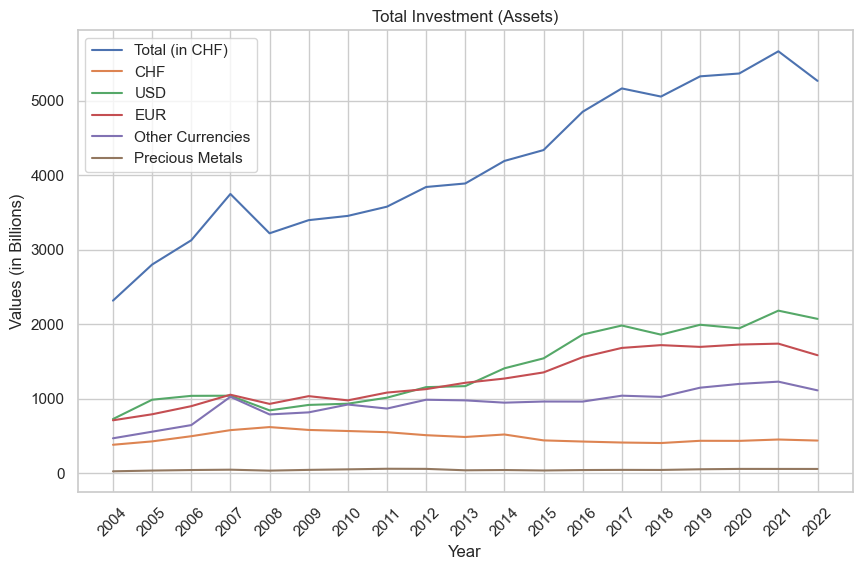

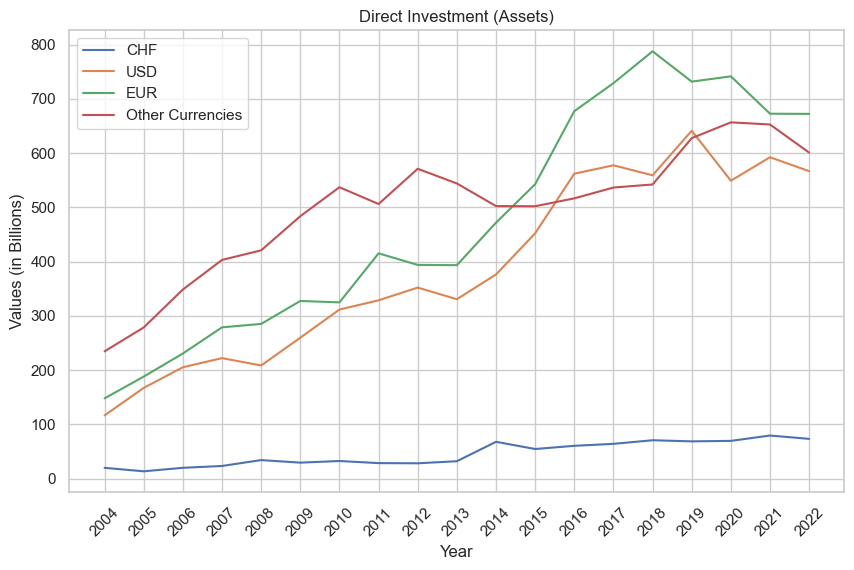

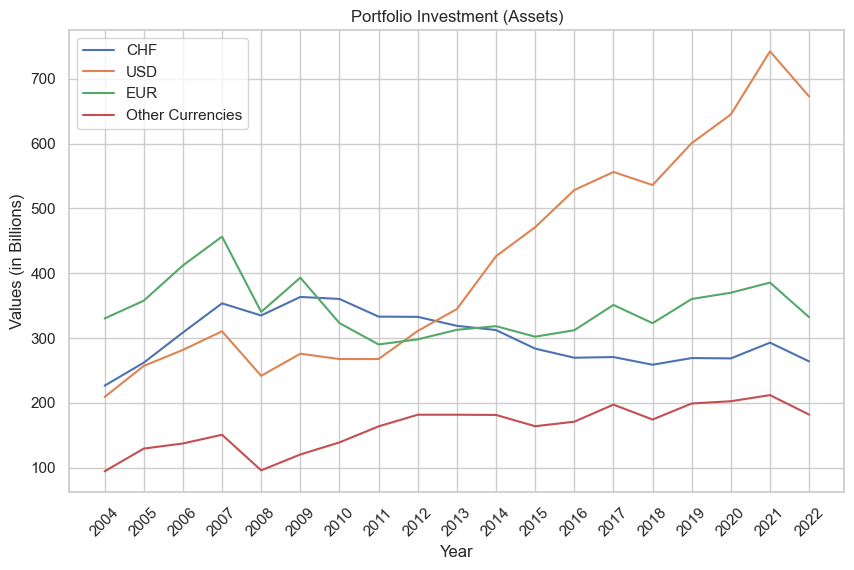

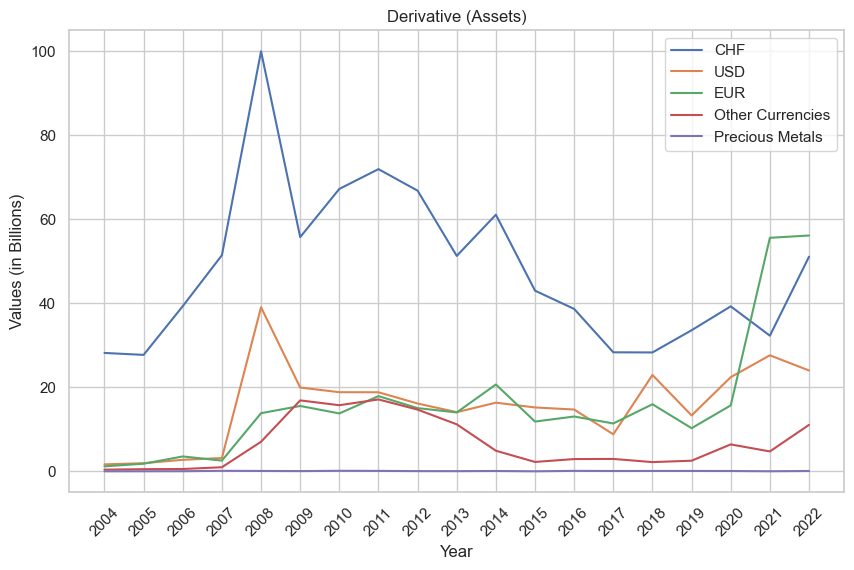

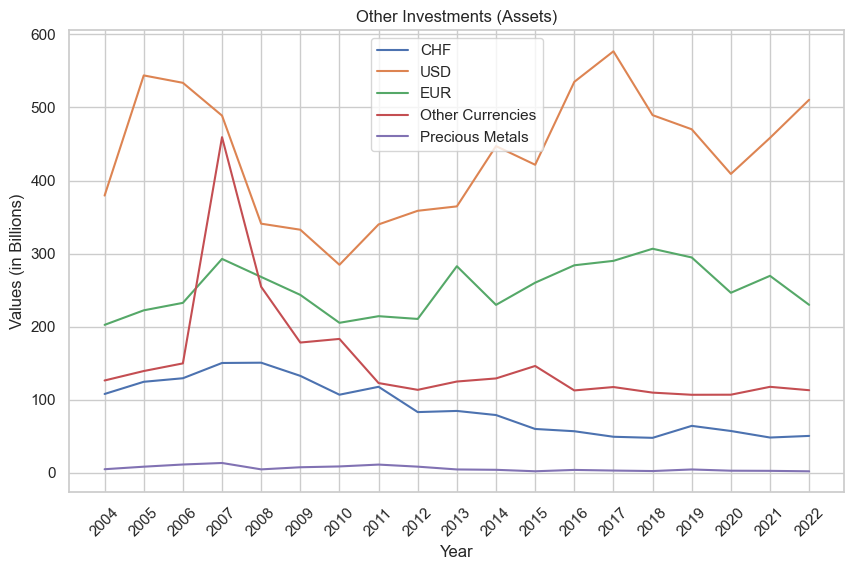

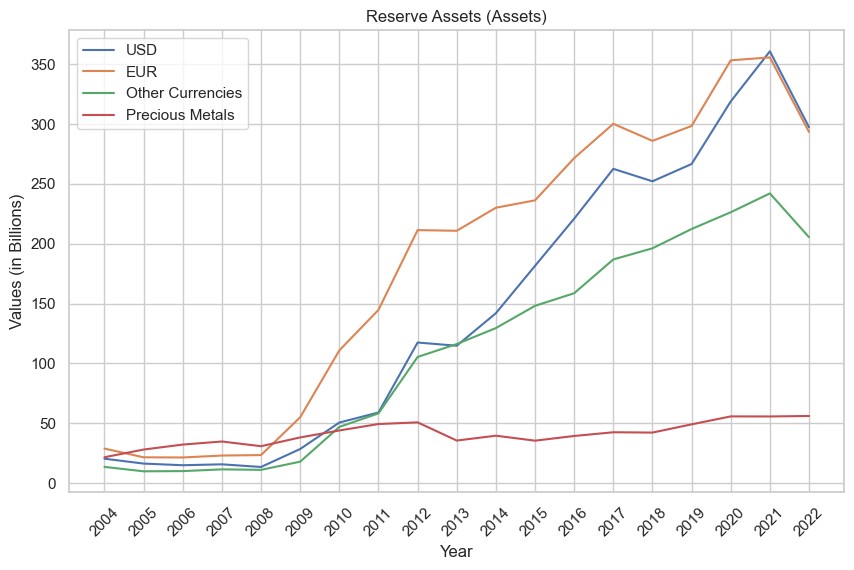

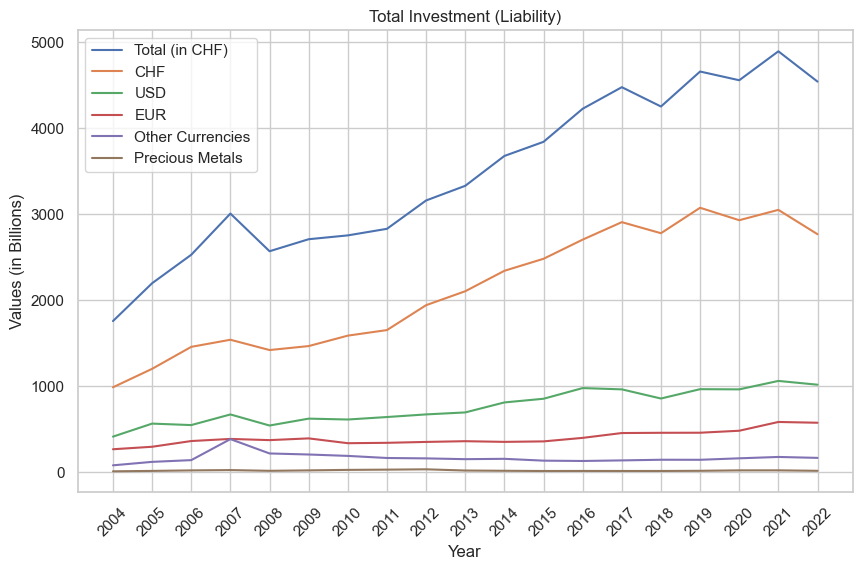

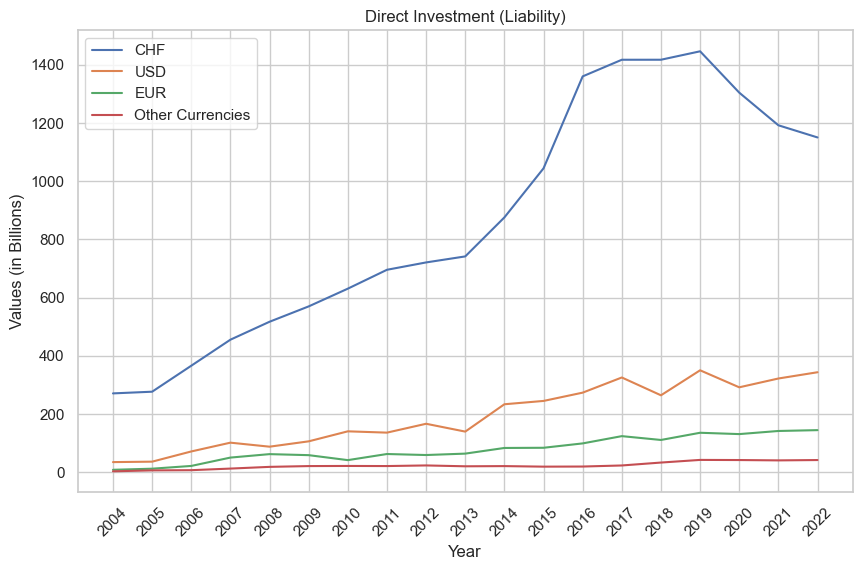

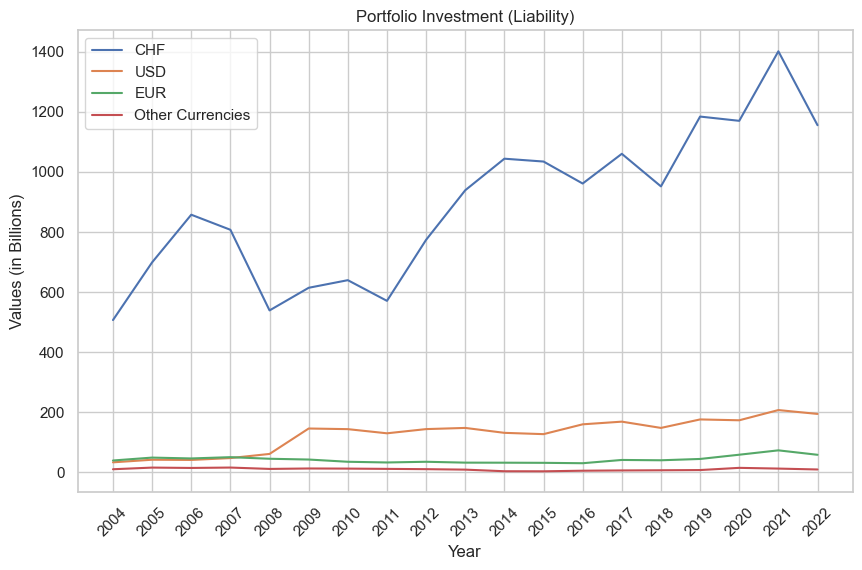

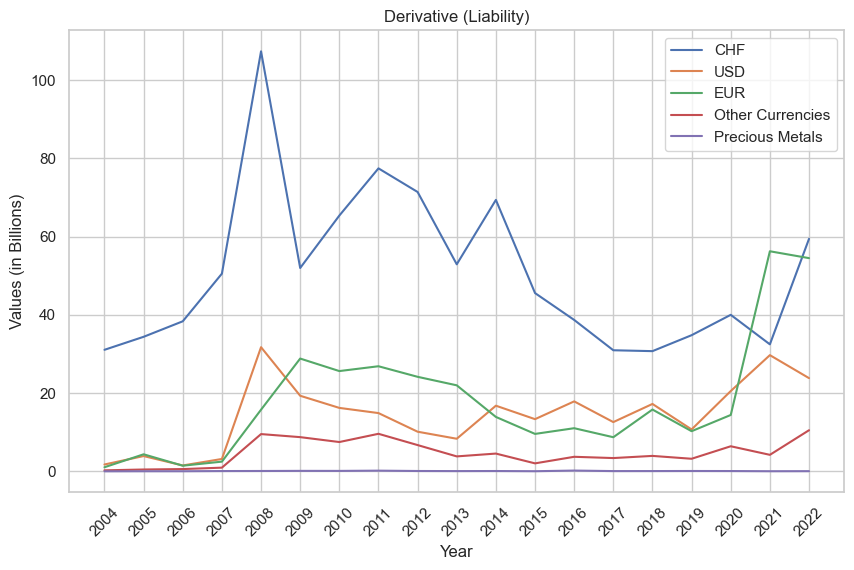

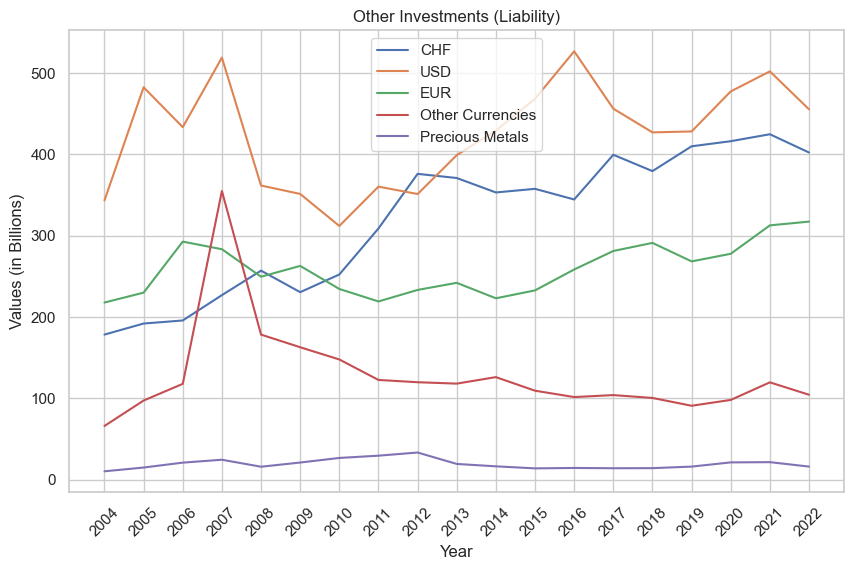

There is no Liability for Reserve Assets.


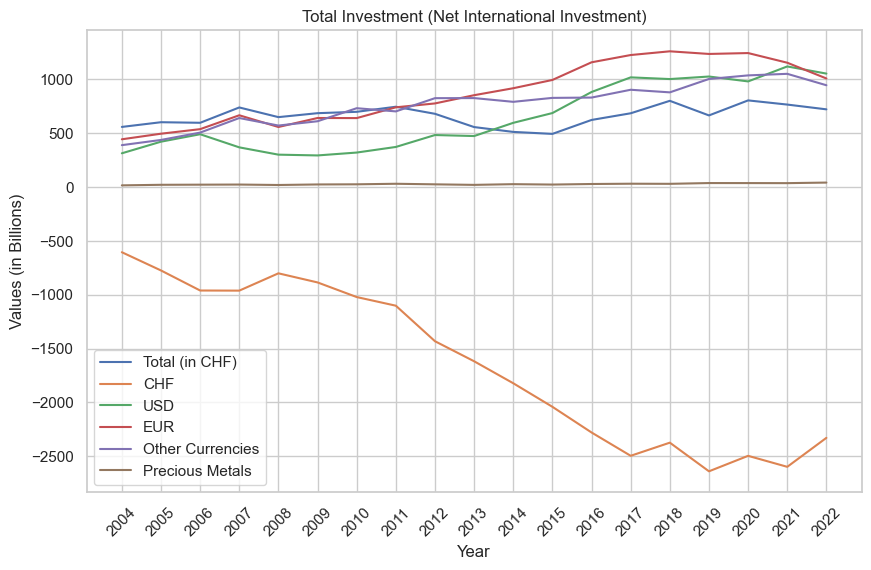

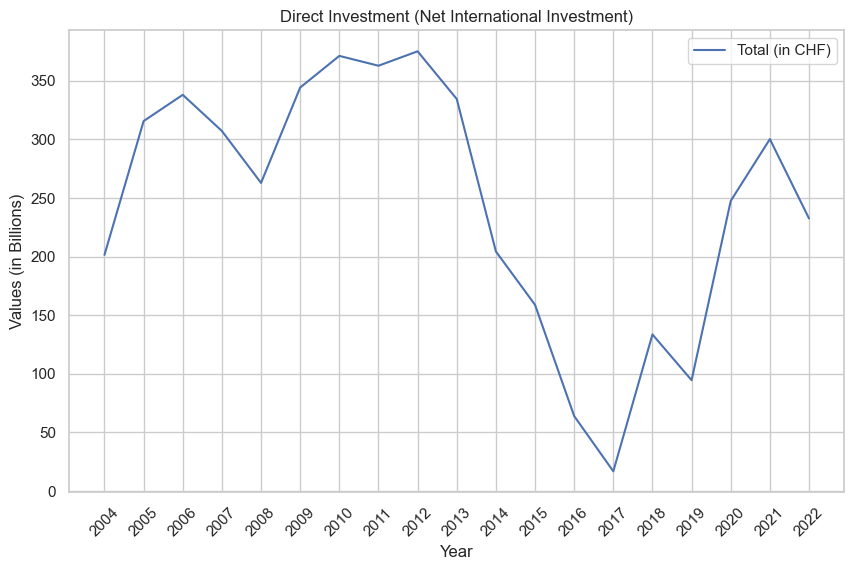

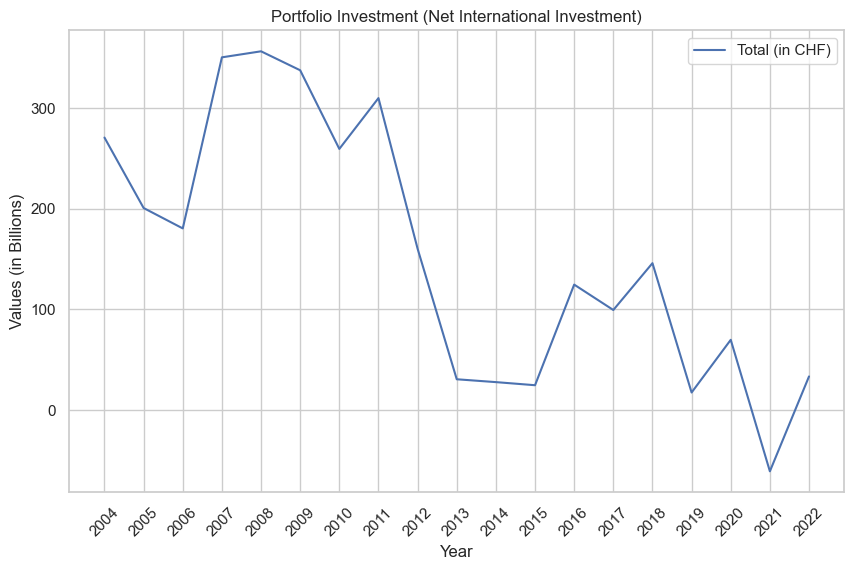

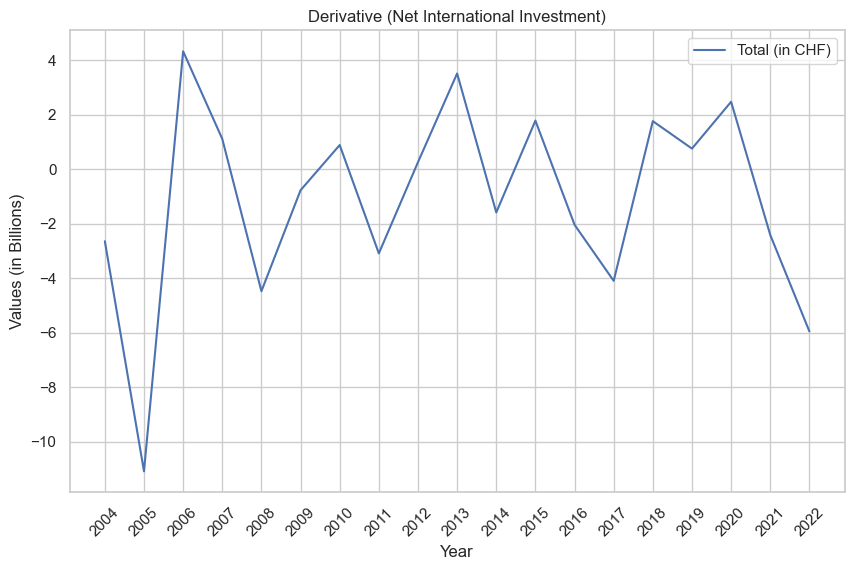

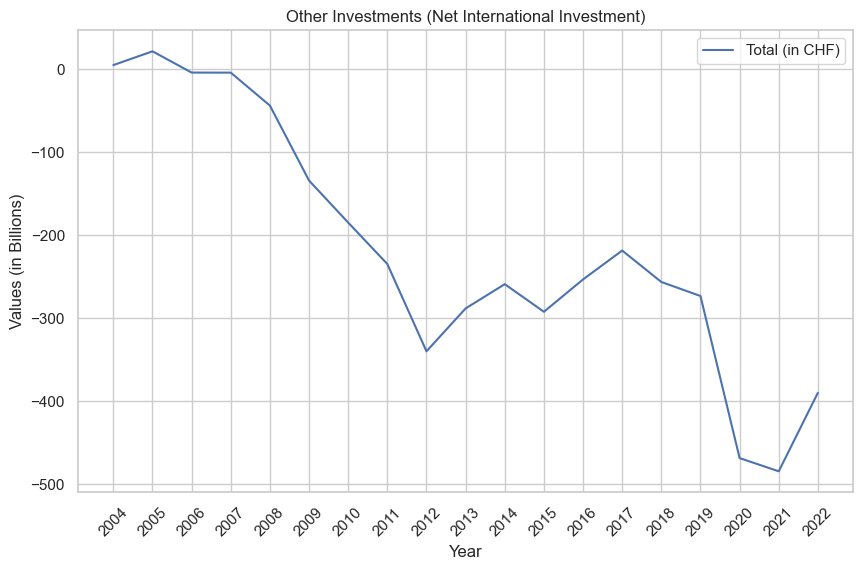

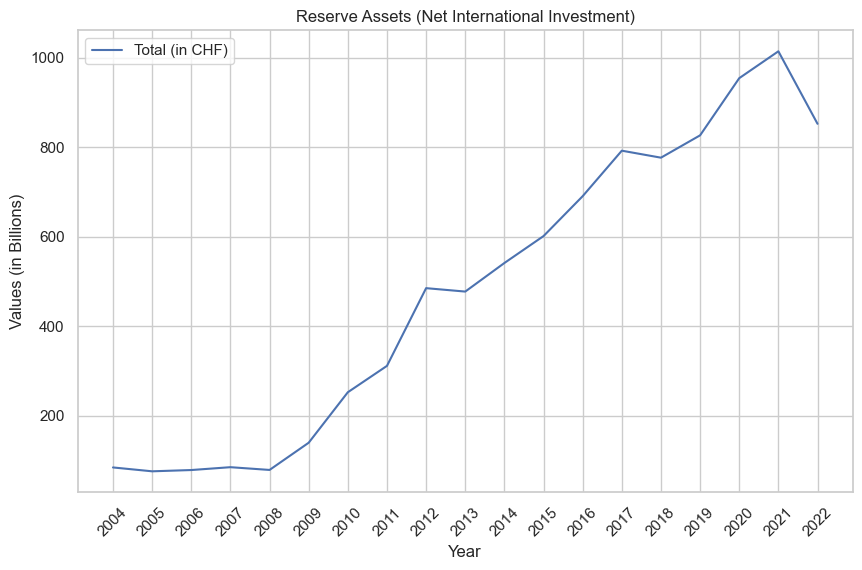

In [18]:
# Layer of columns for the plot
trend_layer = ['Category', 'Investment', 'Currency']

# Plot trends using the data
plot_trend(new_data, trend_layer, category, investment)

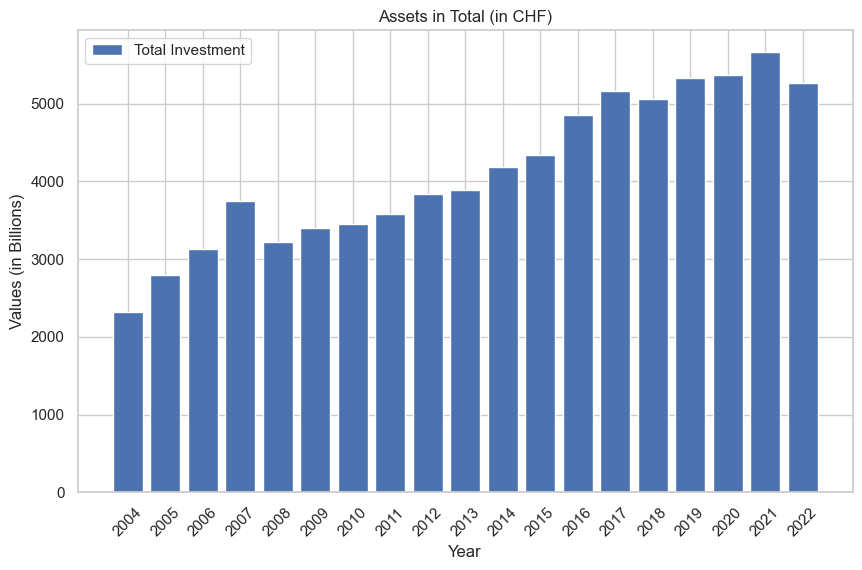

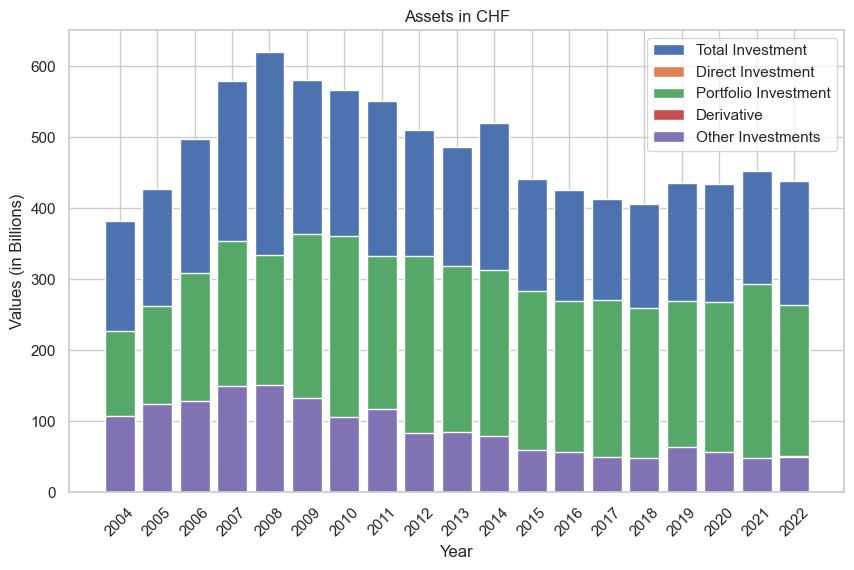

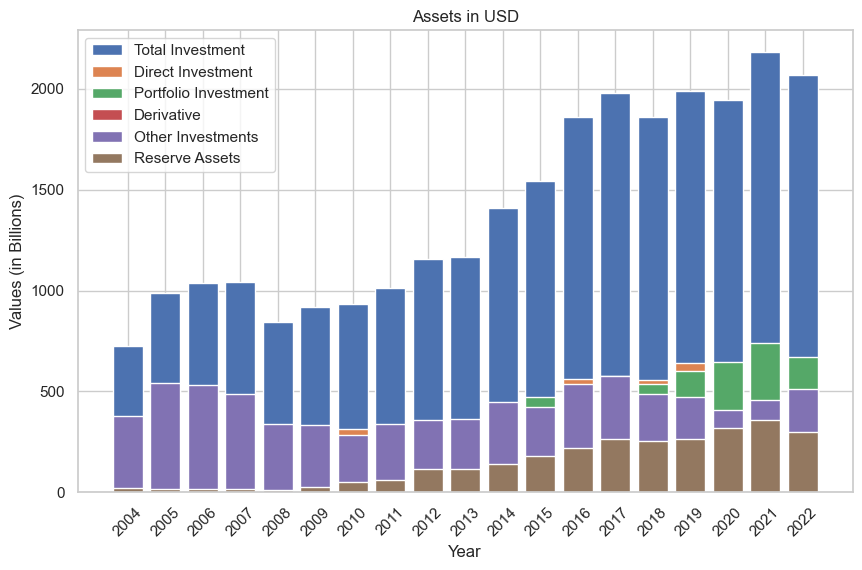

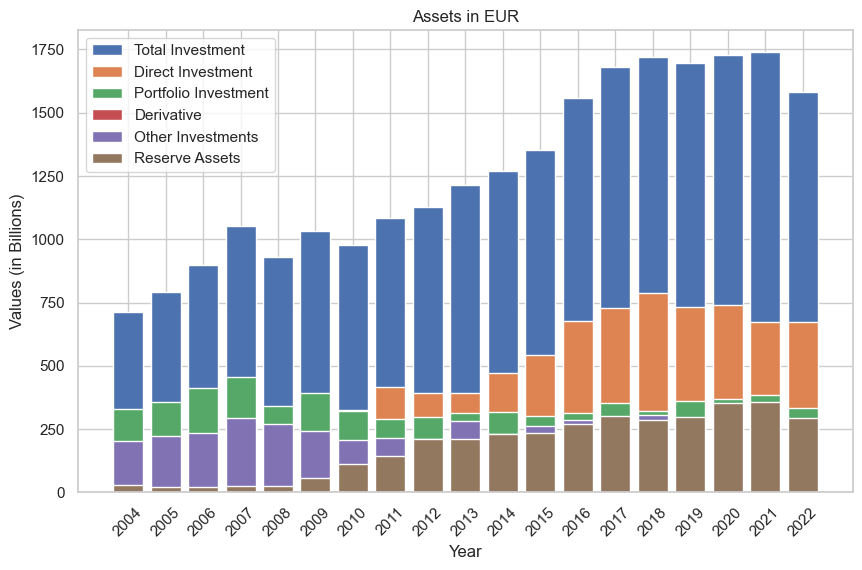

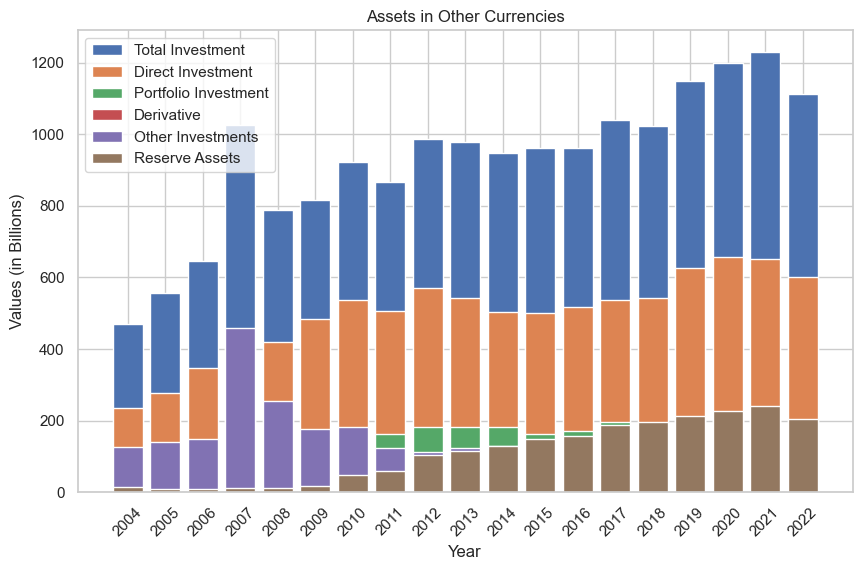

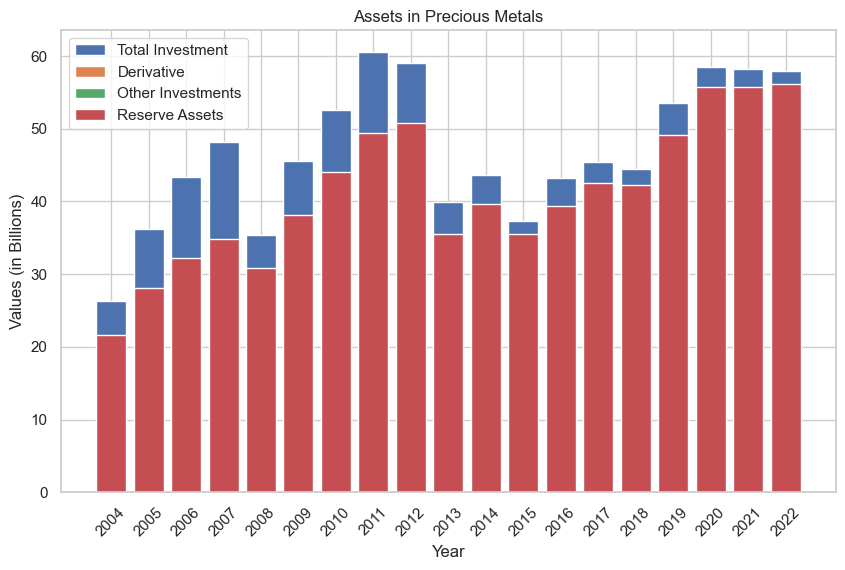

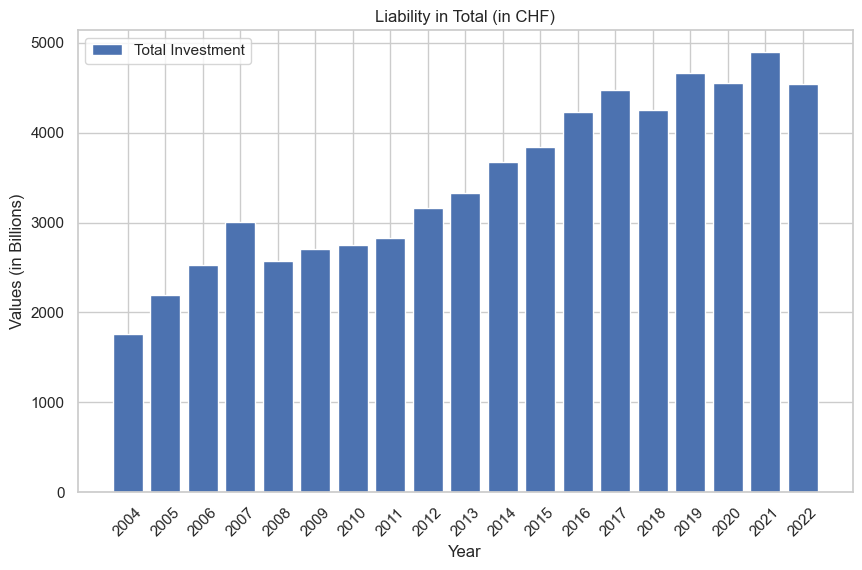

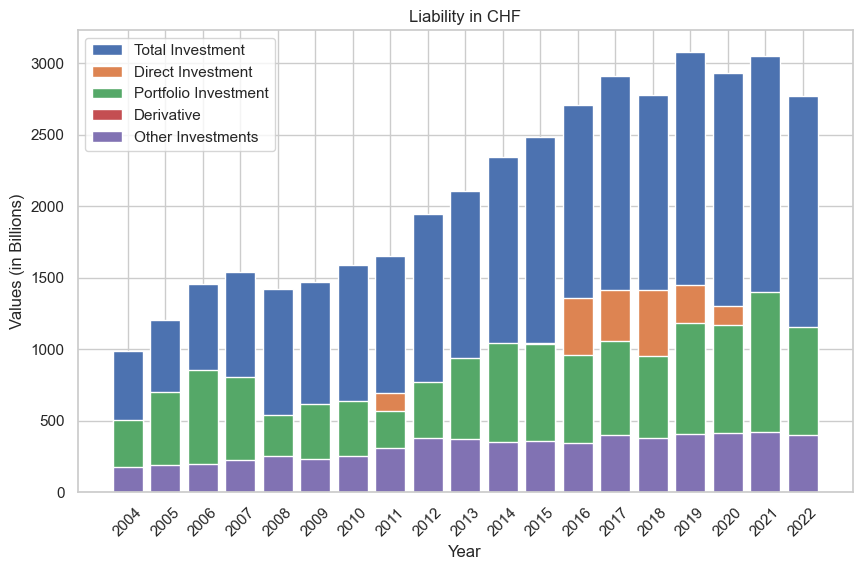

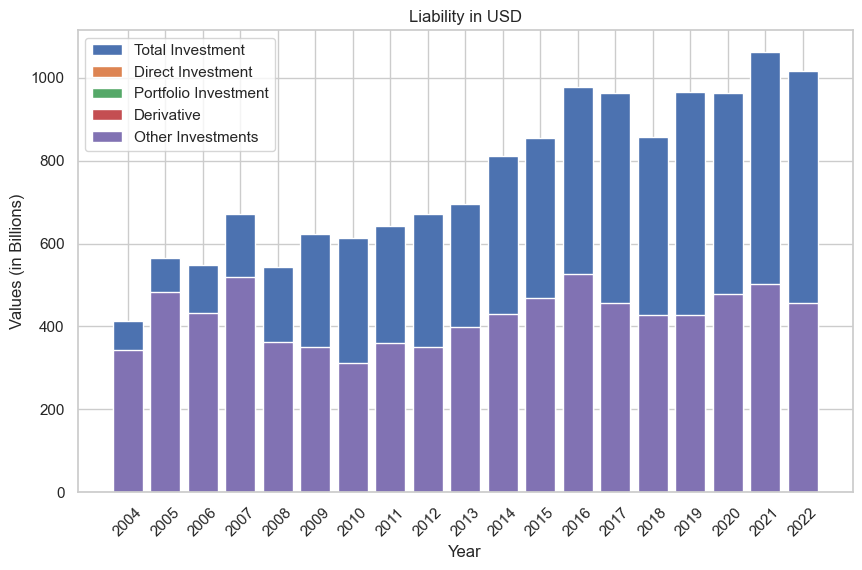

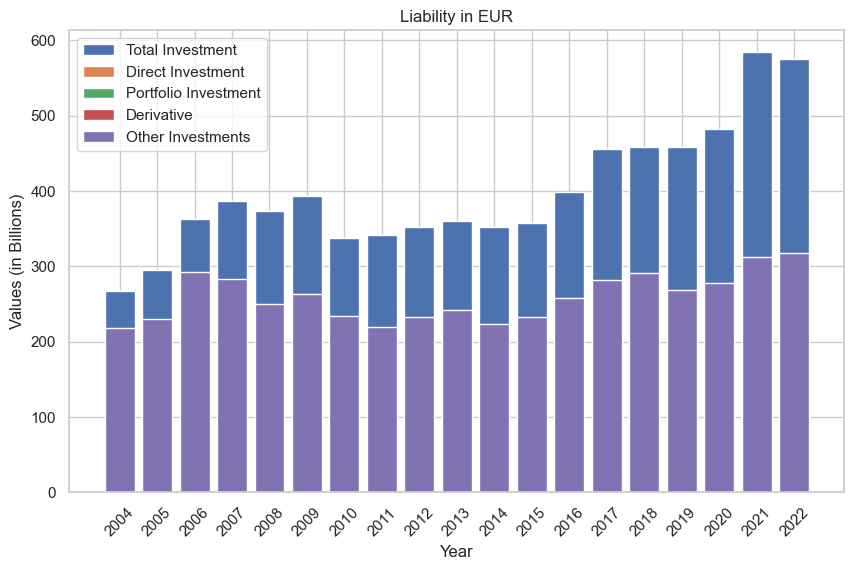

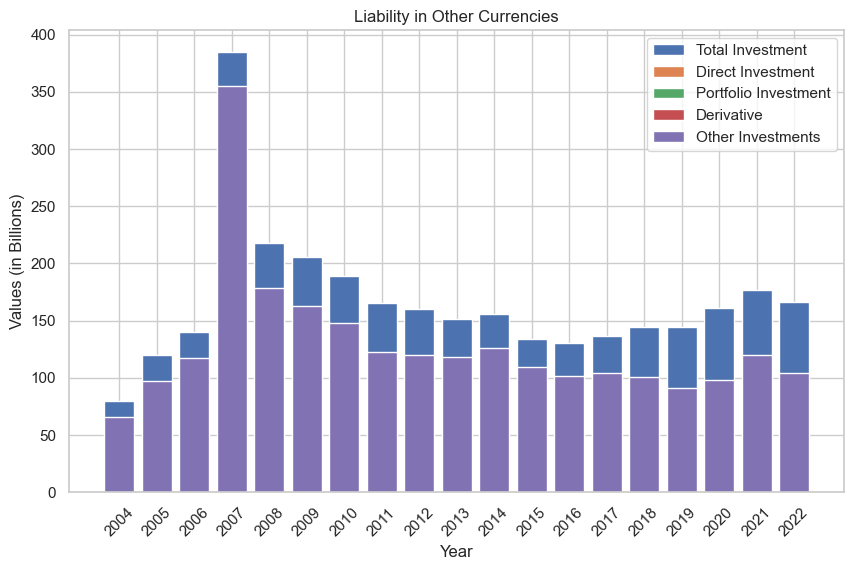

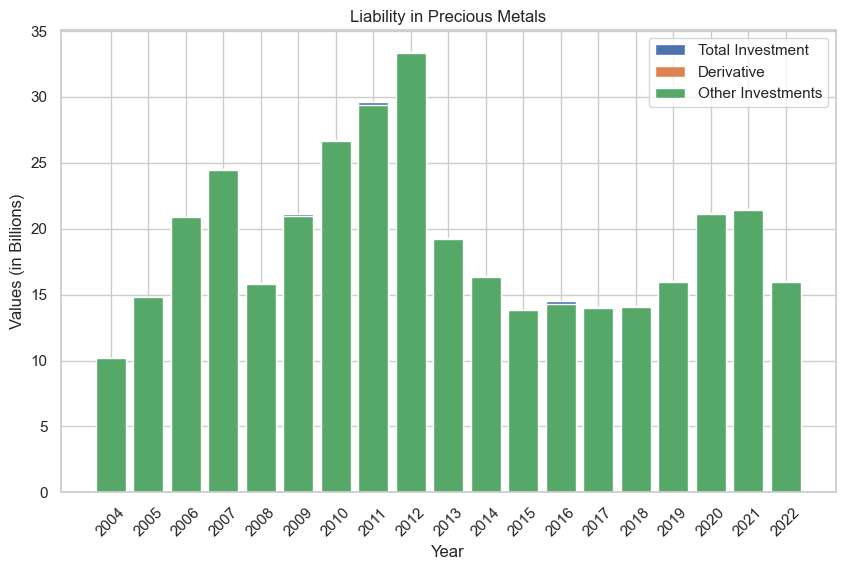

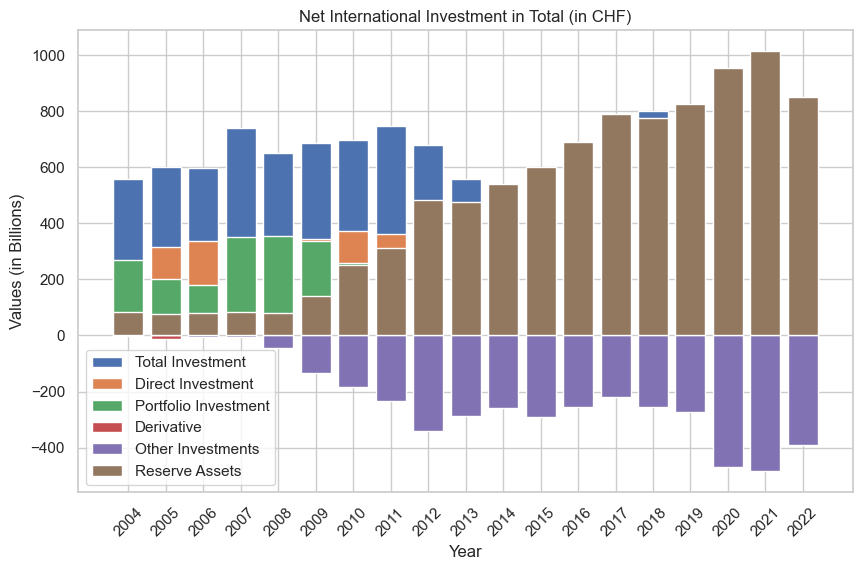

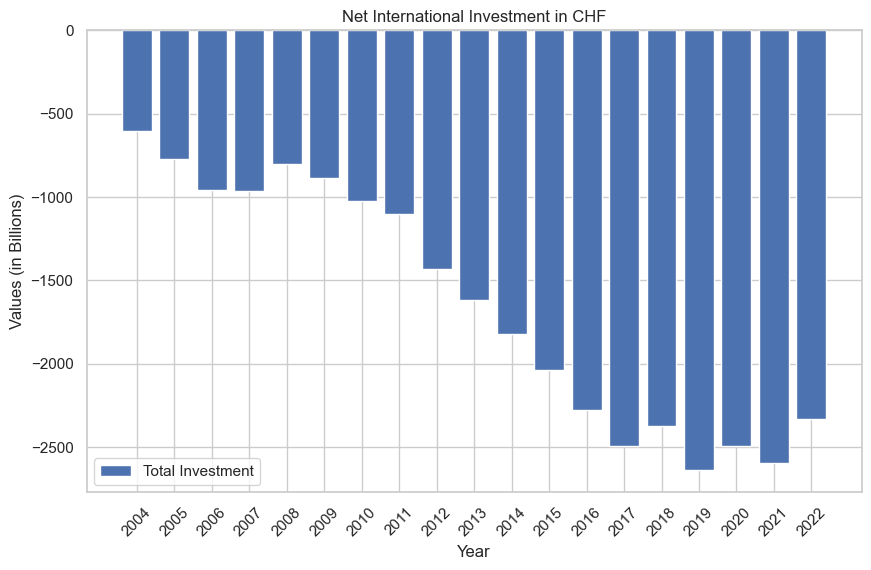

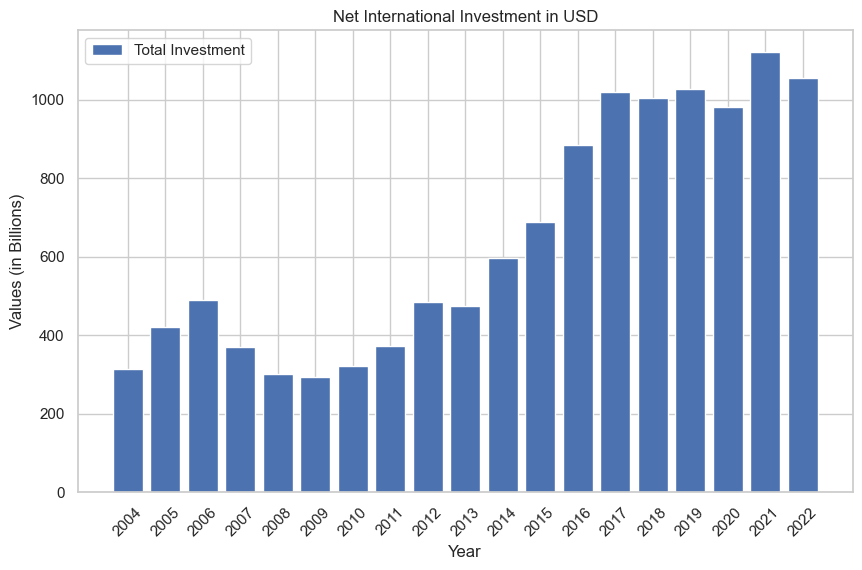

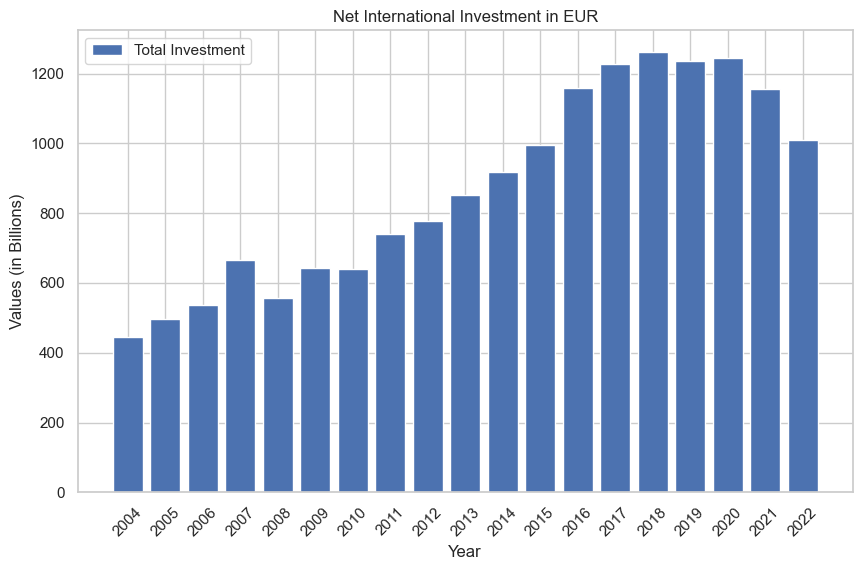

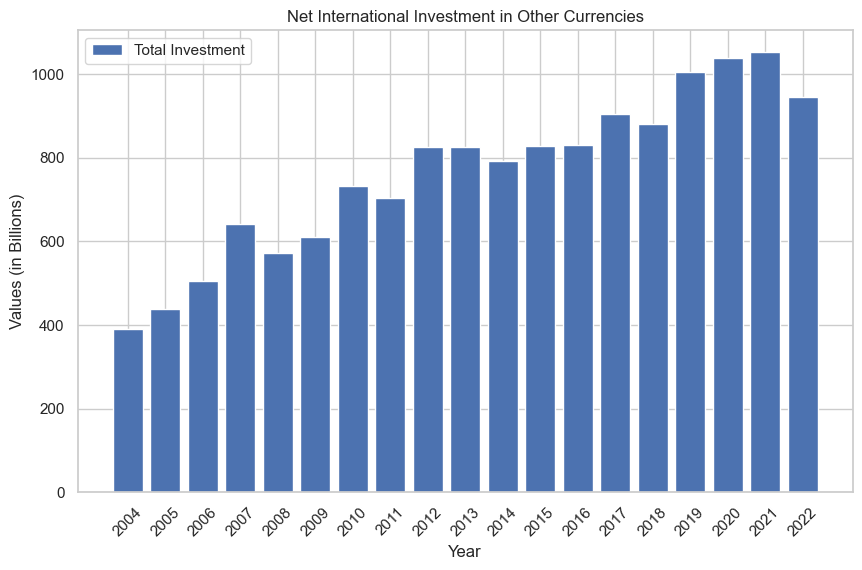

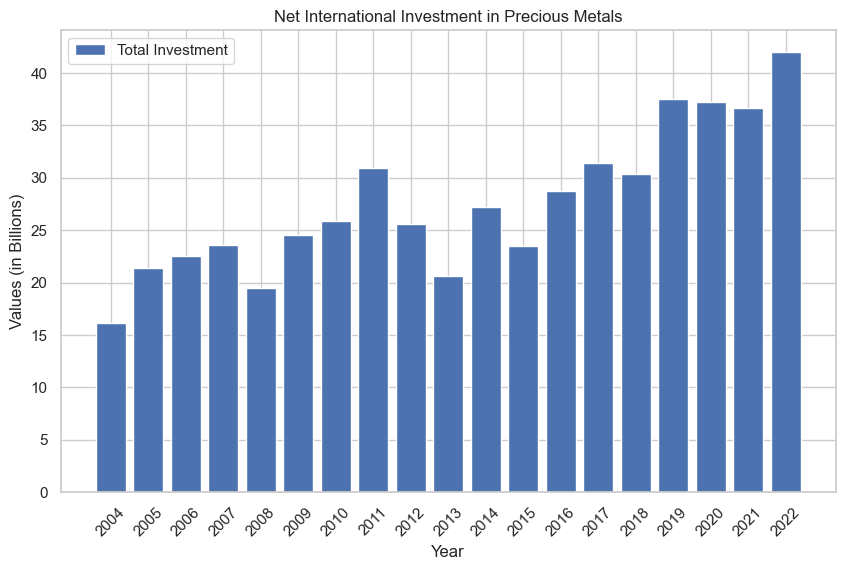

In [19]:
# Layer of columns for the plot
barchart_layer = ['Category', 'Currency', 'Investment']

# Plot stacked bar chart
plot_barchart(new_data, barchart_layer, category, currency)

In [20]:
# Empty database
# CAUTION: THIS CELL WILL DELETE ALL THE GRAPHS IN THE CONNECTED DATABASE
empty_database()

In [21]:
# Write data to graph
write_to_graphdb(new_data)

In [22]:
# Retrive nodes and connections
r = retrive_data(1)

# Display retrived nodes and connections 
display_graph(r)

GraphWidget(layout=Layout(height='500px', width='100%'))

In [23]:
# Retrive nodes and connections
r1 = retrive_data(len(new_data))

# Display retrived nodes and connections 
display_graph(r1)

GraphWidget(layout=Layout(height='500px', width='100%'))